<style type="text/css">
ol {
  counter-reset: item
}
li {
  display: block
}
li:before {
  content: counters(item, ".") " ";
  counter-increment: item
}
</style>
# Maschinelles Lernen - Labor 8 - 18.11.2021
<hr>

#### Prof. Dr. Fabian Transchel - Hochschule Harz
#### Stand: 18.11.2021

<hr>

<div style="border:1px solid black; background-color: #fefeee; padding:15px;">
    <b>Übung:</b><br><br>
    Verwendet werden soll der Datensatz <b>fraud_claims.csv</b>.<br><br>
    <ol>
        <li>Welche Performance erzielt ein einfacher Entscheidungsbaum in Bezug auf die Vorhersage der Zielgröße <b>fraud_reported</b>?</li>
        <li>Welche Merkmale sind relevant?</li>
        <li>Wie könnte man die Imbalance der Output-Klassen adressieren?</li>
    </ol>
</div>

In [80]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
import graphviz
import seaborn as sns
import plotly.express as px

In [165]:
fraud_df = pd.read_csv("fraud_claims.csv")

### Erläuterung einiger Merkmale:
`policy_bind_date` gibt den Tag an ab dem der Versicherungsvertrag greift.
<br>
`policy_csl` steht für das Combined Single Limit des Versicherungsvertrages.
<br>
`policy_deductable` = Selbstkostenanteil
<br>
`umbrella_limit` ist das Auszahlungslimit für Schäden die man bei anderen erzeugt hat (Haftpflichtversicherung)

In [169]:
pd.set_option('display.max_columns', None)
fraud_df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,incident_date,collision_type,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,insured_edu_level_Associate,insured_edu_level_College,insured_edu_level_High School,insured_edu_level_JD,insured_edu_level_MD,insured_edu_level_Masters,insured_edu_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobby_base-jumping,insured_hobby_basketball,insured_hobby_board-games,insured_hobby_bungie-jumping,insured_hobby_camping,insured_hobby_chess,insured_hobby_cross-fit,insured_hobby_dancing,insured_hobby_exercise,insured_hobby_golf,insured_hobby_hiking,insured_hobby_kayaking,insured_hobby_movies,insured_hobby_paintball,insured_hobby_polo,insured_hobby_reading,insured_hobby_skydiving,insured_hobby_sleeping,insured_hobby_video-games,insured_hobby_yachting,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,property_damage_?,property_damage_NO,property_damage_YES
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,0,53300,0,2015-01-25 00:00:00,Side Collision,Police,SC,Columbus,9935 4th Drive,5,1,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,0,0,0,2015-01-21 00:00:00,?,Police,VA,Riverwood,6608 MLK Hwy,8,1,0,0,?,5070,780,780,3510,Mercedes,E400,2007,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,1,35100,0,2015-02-22 00:00:00,Rear Collision,Police,NY,Columbus,7121 Francis Lane,7,3,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,1,48900,-62400,2015-01-10 00:00:00,Front Collision,Police,OH,Arlington,6956 Maple Drive,5,1,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,0,66000,-46000,2015-02-17 00:00:00,?,None,NY,Arlington,3041 3rd Ave,20,1,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Fehlerhafte Zeilen löschen

In [166]:
fraud_df = fraud_df.drop(290)

In [182]:
print("Value Counts: " + str(fraud_df["auto_make"].value_counts()))

Value Counts: Saab          80
Dodge         80
Suburu        80
Nissan        78
Chevrolet     75
Ford          72
BMW           72
Toyota        70
Audi          69
Accura        68
Volkswagen    68
Jeep          67
Mercedes      65
Honda         55
Name: auto_make, dtype: int64


In [129]:
fraud_df[fraud_df["insured_education_level"] == 0]

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported


### Umwandlung des Merkmals `policy_state` in Numerische Werte

`OH` (Ohio) => 1
<br>
`IL` (Illinois) => 2
<br>
`IN` (Indiana) => 3

In [167]:
fraud_df["insured_sex"] = fraud_df["insured_sex"].replace("MALE", 0)
fraud_df["insured_sex"] = fraud_df["insured_sex"].replace("FEMALE", 1)
fraud_df["fraud_reported"] = fraud_df["fraud_reported"].replace("N", 0)
fraud_df["fraud_reported"] = fraud_df["fraud_reported"].replace("Y", 1)

In [180]:
#df_add_edu = pd.get_dummies(fraud_df["insured_education_level"], prefix = "insured_edu_level")
#fraud_df = fraud_df.drop(columns = ["insured_education_level"])
#fraud_df = pd.concat([fraud_df, df_add_edu], axis = 1)

#df_add_occ = pd.get_dummies(fraud_df["insured_occupation"], prefix = "insured_occupation")
#fraud_df = fraud_df.drop(columns = ["insured_occupation"])
#fraud_df = pd.concat([fraud_df, df_add_occ], axis = 1)

#df_add_hob = pd.get_dummies(fraud_df["insured_hobbies"], prefix = "insured_hobby")
#fraud_df = fraud_df.drop(columns = ["insured_hobbies"])
#fraud_df = pd.concat([fraud_df, df_add_hob], axis = 1)

#df_add_relat = pd.get_dummies(fraud_df["insured_relationship"], prefix = "insured_relationship")
#fraud_df = fraud_df.drop(columns = ["insured_relationship"])
#fraud_df = pd.concat([fraud_df, df_add_relat], axis = 1)

#df_add_inc_type = pd.get_dummies(fraud_df["incident_type"], prefix = "incident_type")
#fraud_df = fraud_df.drop(columns = ["incident_type"])
#fraud_df = pd.concat([fraud_df, df_add_inc_type], axis = 1)

#df_add_severity = pd.get_dummies(fraud_df["incident_severity"], prefix = "incident_severity")
#fraud_df = fraud_df.drop(columns = ["incident_severity"])
#fraud_df = pd.concat([fraud_df, df_add_severity], axis = 1)

#df_add_prop_dam = pd.get_dummies(fraud_df["property_damage"], prefix = "property_damage")
#fraud_df = fraud_df.drop(columns = ["property_damage"])
#fraud_df = pd.concat([fraud_df, df_add_prop_dam], axis = 1)

#df_add_state = pd.get_dummies(fraud_df["policy_state"], prefix = "policy_state")
#fraud_df = fraud_df.drop(columns = ["policy_state"])
#fraud_df = pd.concat([fraud_df, df_add_state], axis = 1)

#df_add_inc_state = pd.get_dummies(fraud_df["incident_state"], prefix = "incident_state")
#fraud_df = fraud_df.drop(columns = ["incident_state"])
#fraud_df = pd.concat([fraud_df, df_add_inc_state], axis = 1)

#df_add_rep = pd.get_dummies(fraud_df["police_report_available"], prefix = "police_report_available")
#fraud_df = fraud_df.drop(columns = ["police_report_available"])
#fraud_df = pd.concat([fraud_df, df_add_rep], axis = 1)

#df_add_col_type = pd.get_dummies(fraud_df["collision_type"], prefix = "collision_type")
#fraud_df = fraud_df.drop(columns = ["collision_type"])
#fraud_df = pd.concat([fraud_df, df_add_col_type], axis = 1)

df_add_auth = pd.get_dummies(fraud_df["authorities_contacted"], prefix = "authorities_contacted")
fraud_df = fraud_df.drop(columns = ["authorities_contacted"])
fraud_df = pd.concat([fraud_df, df_add_auth], axis = 1)

fraud_df

,months_as_customer,age,policy_number,policy_bind_date,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,incident_date,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,insured_edu_level_Associate,insured_edu_level_College,insured_edu_level_High School,insured_edu_level_JD,insured_edu_level_MD,insured_edu_level_Masters,insured_edu_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobby_base-jumping,insured_hobby_basketball,insured_hobby_board-games,insured_hobby_bungie-jumping,insured_hobby_camping,insured_hobby_chess,insured_hobby_cross-fit,insured_hobby_dancing,insured_hobby_exercise,insured_hobby_golf,insured_hobby_hiking,insured_hobby_kayaking,insured_hobby_movies,insured_hobby_paintball,insured_hobby_polo,insured_hobby_reading,insured_hobby_skydiving,insured_hobby_sleeping,insured_hobby_video-games,insured_hobby_yachting,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,property_damage_?,property_damage_NO,property_damage_YES,policy_state_IL,policy_state_IN,policy_state_OH,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Arlington,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,police_report_available_?,police_report_available_NO,police_report_available_YES,collision_type_?,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
0,328,48,521585,2014-10-17 00:00:00,250/500,1000,1406.91,0,466132,0,53300,0,2015-01-25 00:00:00,9935 4th Drive,5,1,1,2,71610,6510,13020,52080,Saab,92x,2004,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,228,42,342868,2006-06-27 00:00:00,250/500,2000,1197.22,5000000,468176,0,0,0,2015-01-21 00:00:00,6608 MLK Hwy,8,1,0,0,5070,780,780,3510,Mercedes,E400,2007,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
2,134,29,687698,2000-09-06 00:00:00,100/300,2000,1413.14,5000000,430632,1,35100,0,2015-02-22 00:00:00,7121 Francis Lane,7,3,2,3,34650,7700,3850,23100,Dodge,RAM,2007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,256,41,227811,1990-05-25 00:00:00,250/500,2000,1415.74,6000000,608117,1,48900,-62400,2015-01-10 00:00:00,6956 Maple Drive,5,1,1,2,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,

In [66]:
summe_1 = 0
summe_0 = 0

for i in range(len(fraud_df)):
    if fraud_df.at[i, "umbrella_limit"] < 0:
        summe_1 += 1
    elif fraud_df.at[i, "umbrella_limit"] == np.nan:
        summe_0 += 1
        
print("Anzahl kleiner 0: " + str(summe_1))
print("Anzahl nicht int: " + str(summe_0))

Anzahl kleiner 0: 1
Anzahl nicht int: 0


In [67]:
fraud_df[fraud_df["umbrella_limit"] < 0] = 0

In [68]:
fraud_df[fraud_df["umbrella_limit"] < 0]

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported


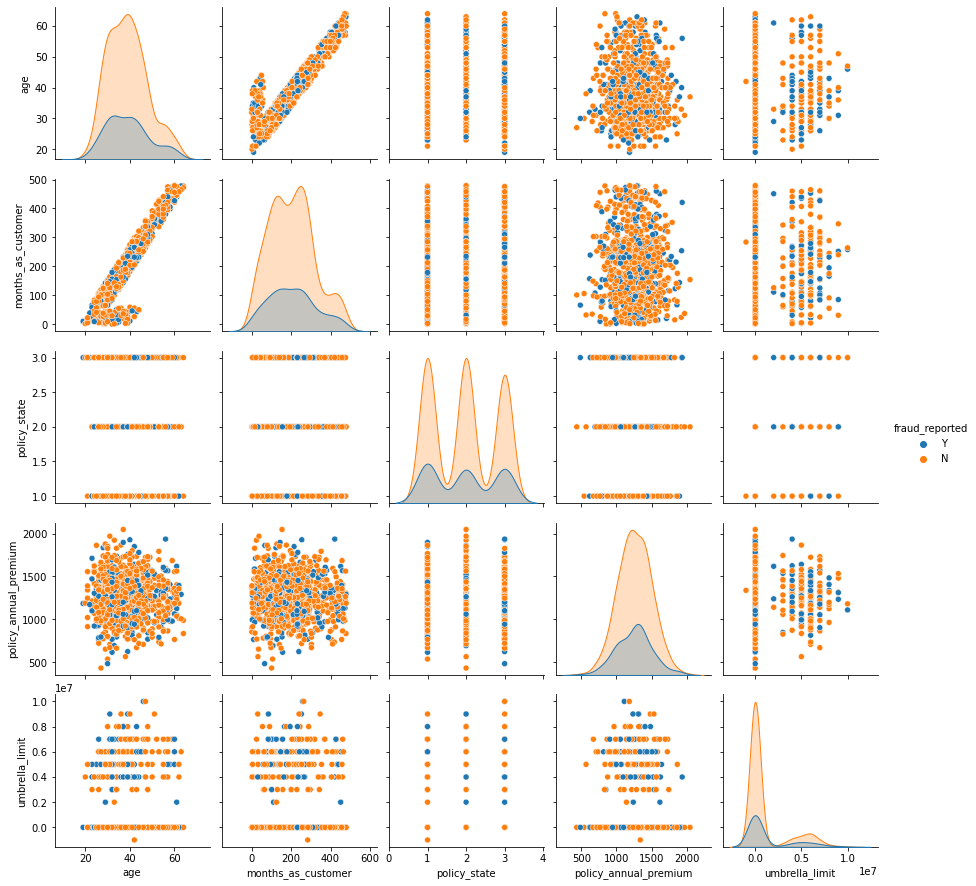

In [6]:
sns.pairplot(fraud_df, hue = "fraud_reported",
            x_vars = ["age", "months_as_customer", "policy_state", "policy_annual_premium", "umbrella_limit"],
            y_vars = ["age", "months_as_customer", "policy_state", "policy_annual_premium", "umbrella_limit"]) 

### Interpretation des ersten Pairplot:

__"Haken" zwischen Alter und months_as_customer:__
- `months_as_customer` wächst gleichmäßig mit dem Alter an
- Verträge konnten früher nur abgeschlossen werden, wenn man jünger als 30 Jahre alt war
- Vor einigen Jahren wurde diese Altersgrenze auf 40 Jahre erhöht
- Verträge fangen frühstens mit 19 Jahren an

__Umbrella_limit:__
- frauds treten vorallem bei Verträgen auf die ein Umbrella_limit haben

__policy_states:__
- Die Verteilung über die drei Staaten ist recht gleichmäßig
- Indiana (3) hat eine etwas geringere Anzahl an Verträgen
- Die Anzahl der Frauds pro Staat ist sehr ähnlich

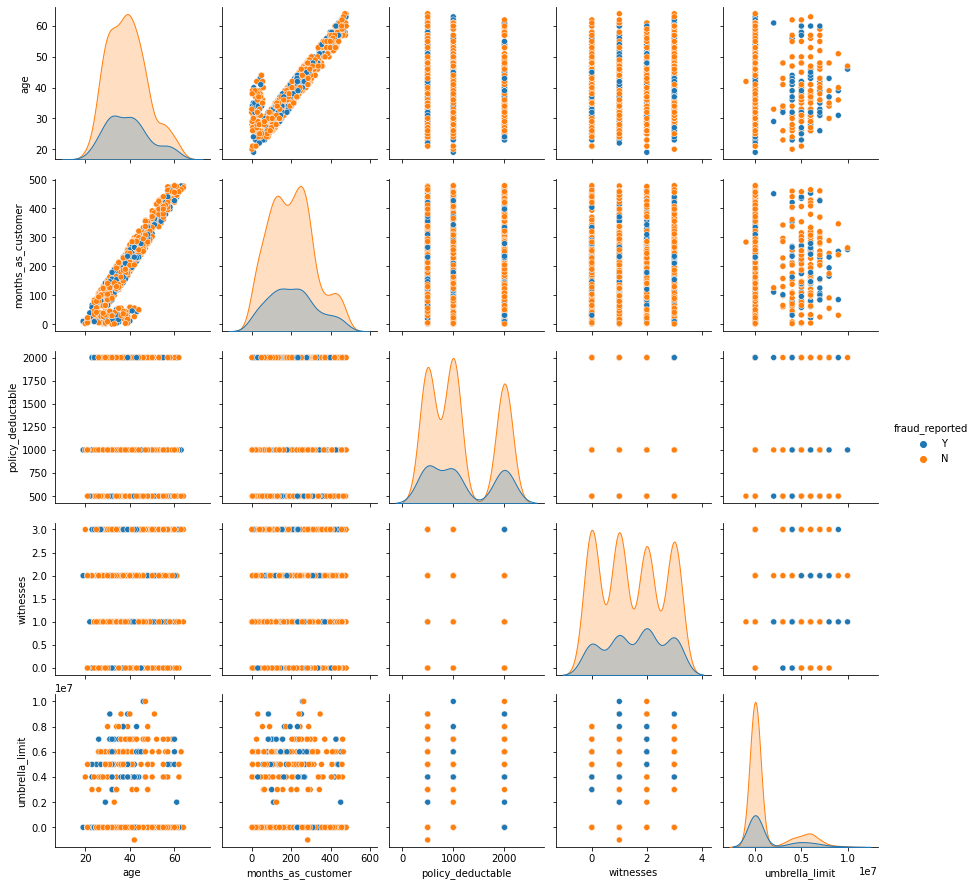

In [7]:
sns.pairplot(fraud_df, hue = "fraud_reported",
            x_vars = ["age", "", "policy_deductable", "witnesses", "umbrella_limit"],
            y_vars = ["age", "months_as_customer", "policy_deductable", "witnesses", "umbrella_limit"]) 

### Interpretation des zweiten Pairplot:
- witnesses und policy_deductable scheinen uninteressant zu sein

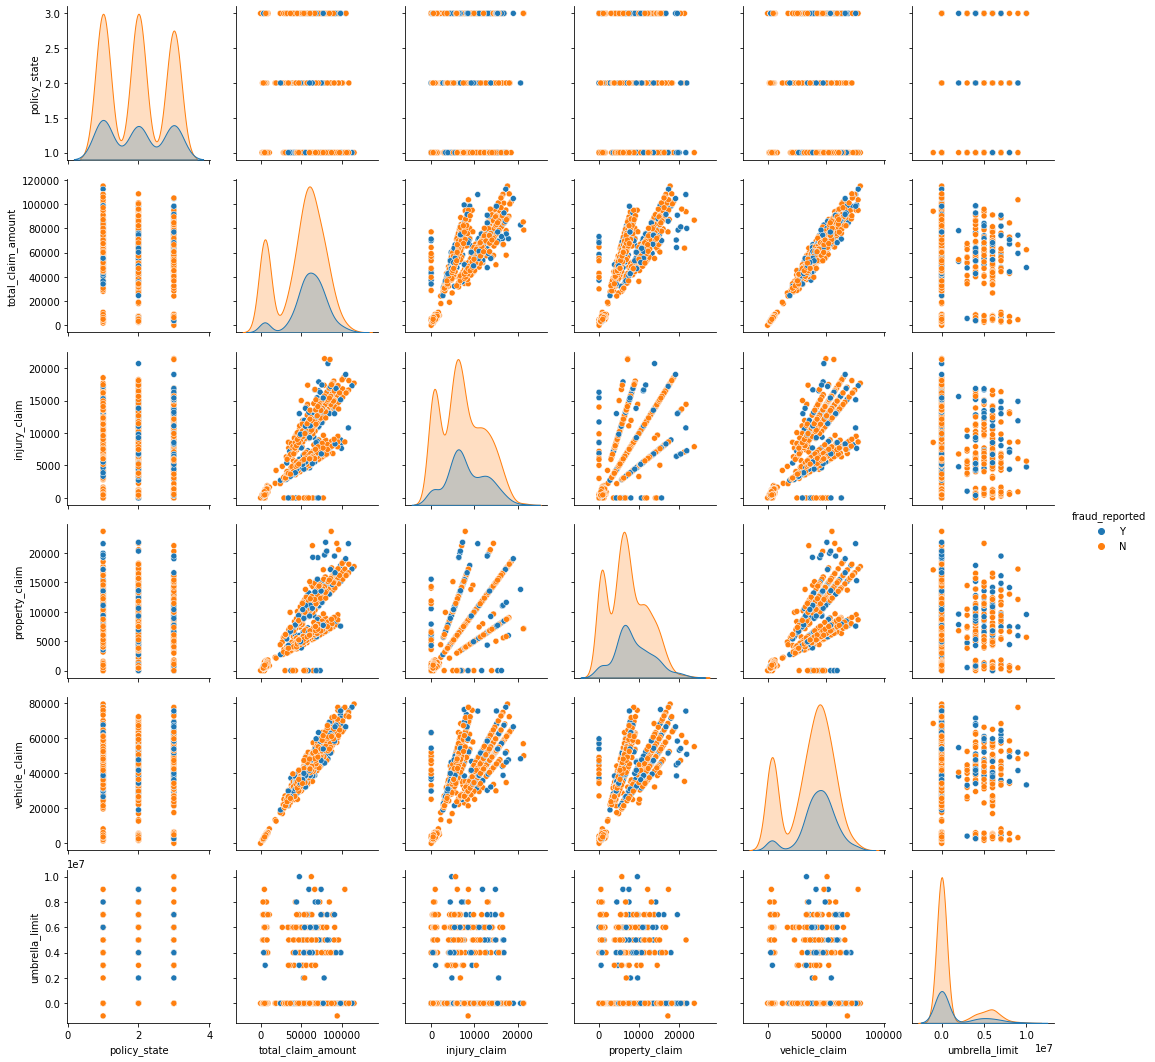

In [19]:
sns.pairplot(fraud_df, hue = "fraud_reported",
            x_vars = ["policy_state", "total_claim_amount", "injury_claim","property_claim", "vehicle_claim", "umbrella_limit"],
            y_vars = ["policy_state", "total_claim_amount", "injury_claim","property_claim", "vehicle_claim", "umbrella_limit"]) 

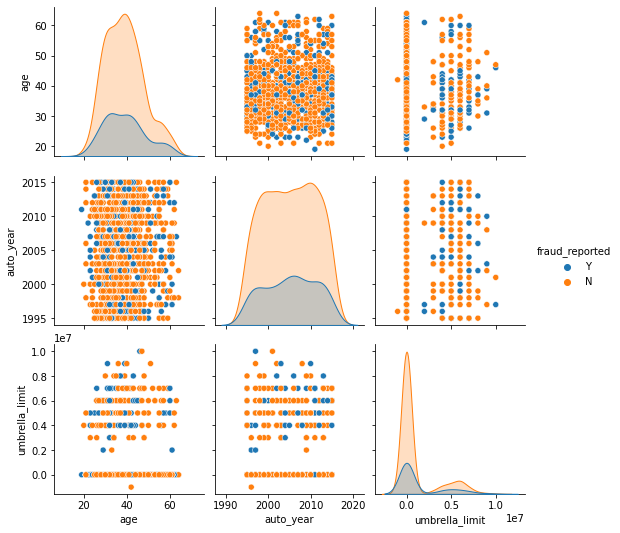

In [30]:
sns.pairplot(fraud_df, hue = "fraud_reported",
            x_vars = ["age", "auto_year", "umbrella_limit"],
            y_vars = ["age", "auto_year", "umbrella_limit"]) 

In [181]:
fraud_df

,months_as_customer,age,policy_number,policy_bind_date,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,incident_date,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,insured_edu_level_Associate,insured_edu_level_College,insured_edu_level_High School,insured_edu_level_JD,insured_edu_level_MD,insured_edu_level_Masters,insured_edu_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobby_base-jumping,insured_hobby_basketball,insured_hobby_board-games,insured_hobby_bungie-jumping,insured_hobby_camping,insured_hobby_chess,insured_hobby_cross-fit,insured_hobby_dancing,insured_hobby_exercise,insured_hobby_golf,insured_hobby_hiking,insured_hobby_kayaking,insured_hobby_movies,insured_hobby_paintball,insured_hobby_polo,insured_hobby_reading,insured_hobby_skydiving,insured_hobby_sleeping,insured_hobby_video-games,insured_hobby_yachting,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,property_damage_?,property_damage_NO,property_damage_YES,policy_state_IL,policy_state_IN,policy_state_OH,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Arlington,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,police_report_available_?,police_report_available_NO,police_report_available_YES,collision_type_?,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
0,328,48,521585,2014-10-17 00:00:00,250/500,1000,1406.91,0,466132,0,53300,0,2015-01-25 00:00:00,9935 4th Drive,5,1,1,2,71610,6510,13020,52080,Saab,92x,2004,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,228,42,342868,2006-06-27 00:00:00,250/500,2000,1197.22,5000000,468176,0,0,0,2015-01-21 00:00:00,6608 MLK Hwy,8,1,0,0,5070,780,780,3510,Mercedes,E400,2007,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
2,134,29,687698,2000-09-06 00:00:00,100/300,2000,1413.14,5000000,430632,1,35100,0,2015-02-22 00:00:00,7121 Francis Lane,7,3,2,3,34650,7700,3850,23100,Dodge,RAM,2007,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,256,41,227811,1990-05-25 00:00:00,250/500,2000,1415.74,6000000,608117,1,48900,-62400,2015-01-10 00:00:00,6956 Maple Drive,5,1,1,2,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,

## Decision Tree

In [183]:
df_training = fraud_df.drop(columns = ["policy_number", "policy_bind_date", "policy_csl", "insured_zip", "auto_make", "auto_model", "fraud_reported", "incident_date", "incident_location"])
df_training

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,insured_edu_level_Associate,insured_edu_level_College,insured_edu_level_High School,insured_edu_level_JD,insured_edu_level_MD,insured_edu_level_Masters,insured_edu_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobby_base-jumping,insured_hobby_basketball,insured_hobby_board-games,insured_hobby_bungie-jumping,insured_hobby_camping,insured_hobby_chess,insured_hobby_cross-fit,insured_hobby_dancing,insured_hobby_exercise,insured_hobby_golf,insured_hobby_hiking,insured_hobby_kayaking,insured_hobby_movies,insured_hobby_paintball,insured_hobby_polo,insured_hobby_reading,insured_hobby_skydiving,insured_hobby_sleeping,insured_hobby_video-games,insured_hobby_yachting,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,property_damage_?,property_damage_NO,property_damage_YES,policy_state_IL,policy_state_IN,policy_state_OH,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Arlington,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,police_report_available_?,police_report_available_NO,police_report_available_YES,collision_type_?,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
0,328,48,1000,1406.91,0,0,53300,0,5,1,1,2,71610,6510,13020,52080,2004,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,228,42,2000,1197.22,5000000,0,0,0,8,1,0,0,5070,780,780,3510,2007,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
2,134,29,2000,1413.14,5000000,1,35100,0,7,3,2,3,34650,7700,3850,23100,2007,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,256,41,2000,1415.74,6000000,1,48900,-62400,5,1,1,2,63400,6340,6340,50720,2014,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,228,44,1000,1583.91,6000000,0,66000,-46000,20,1,0,1,6500,1300,650,4550,2009,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [184]:
X = df_training
Y = fraud_df["fraud_reported"]

In [185]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [186]:
clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split=30, max_leaf_nodes=5, random_state = 42)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=5, min_samples_split=30,
                       random_state=42)

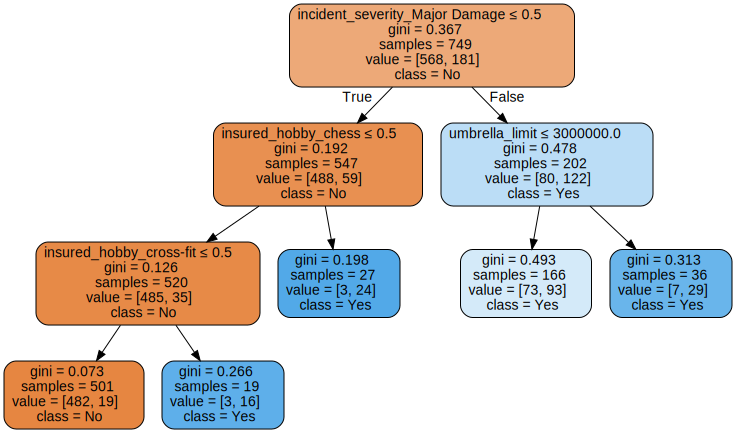

In [187]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                    feature_names=X.columns,  
                    class_names = ["No", "Yes"],
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [40]:
clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

## XGBoost

In [188]:
param = {"learning_rate" : 0.01,
        "max_depth" : 3,
        "use_label_encoder" : False,
        "objective" : "multi:softprob",
        "booster" : "gbtree",
        "n_estimators" : 1000}

xgb_clf = xgb.XGBClassifier(kwargs = param, random_state = 42)
xgb_clf.fit(X_train, Y_train)

/home/giuliano/anaconda3/envs/test39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:58] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              kwargs={'booster': 'gbtree', 'learning_rate': 0.01,
                      'max_depth': 3, 'n_estimators': 1000,
                      'objective': 'multi:softprob',
                      'use_label_encoder': False},
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

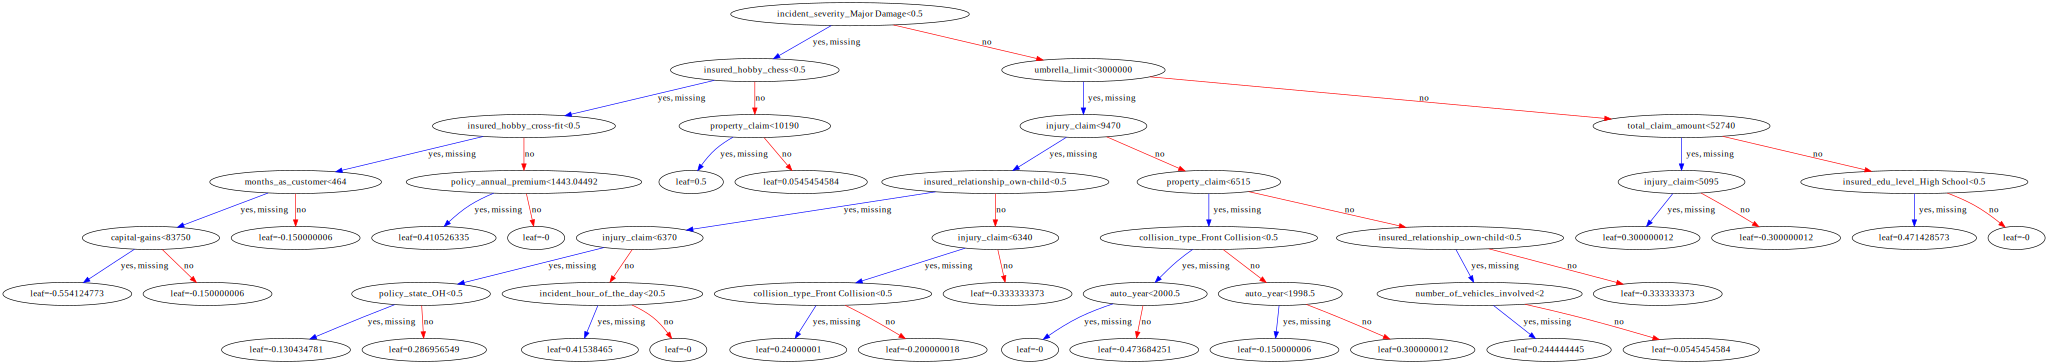

In [189]:
dot_data = xgb.to_graphviz(xgb_clf)  
#graph = graphviz.Source(dot_data)  
#graph
dot_data

In [87]:
xgb_clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

## Scores

In [190]:
xgb_train_pred = xgb_clf.predict(X_train)
xgb_test_pred = xgb_clf.predict(X_test)

clf_train_pred = clf.predict(X_train)
clf_test_pred = clf.predict(X_test)

In [191]:
print("+++ Train Scores for the Decision Tree +++")
print("Precision: "+str(sklearn.metrics.precision_score(Y_train, clf_train_pred)))
print("Accuracy: " + str(sklearn.metrics.accuracy_score(Y_train, clf_train_pred)))
print("Jaccard Score: " + str(sklearn.metrics.jaccard_score(Y_train, clf_train_pred)))
print("Confusion Matrix: \n"+str(sklearn.metrics.confusion_matrix(Y_train, clf_train_pred)))
print()
print("+++ Test Scores for the Decision Tree +++")
print("Precision: "+str(sklearn.metrics.precision_score(Y_test, clf_test_pred)))
print("Accuracy: " + str(sklearn.metrics.accuracy_score(Y_test, clf_test_pred)))
print("Jaccard Score: " + str(sklearn.metrics.jaccard_score(Y_test, clf_test_pred)))
print("Confusion Matrix: \n"+str(sklearn.metrics.confusion_matrix(Y_test, clf_test_pred)))
print()
print()
print("+++ Train Scores for XGBoost Classifier +++")
print("Precision: "+str(sklearn.metrics.precision_score(Y_train, xgb_train_pred)))
print("Accuracy: " + str(sklearn.metrics.accuracy_score(Y_train, xgb_train_pred)))
print("Jaccard Score: " + str(sklearn.metrics.jaccard_score(Y_train, xgb_train_pred)))
print("Confusion Matrix: \n"+str(sklearn.metrics.confusion_matrix(Y_train, xgb_train_pred)))
print()
print("+++ Test Scores for XGBoost Classifier +++")
print("Precision: "+str(sklearn.metrics.precision_score(Y_test, xgb_test_pred)))
print("Accuracy: " + str(sklearn.metrics.accuracy_score(Y_test, xgb_test_pred)))
print("Jaccard Score: " + str(sklearn.metrics.jaccard_score(Y_test, xgb_test_pred)))
print("Confusion Matrix: \n"+str(sklearn.metrics.confusion_matrix(Y_test, xgb_test_pred)))

+++ Train Scores for the Decision Tree +++
Precision: 0.6532258064516129
Accuracy: 0.8598130841121495
Jaccard Score: 0.6067415730337079
Confusion Matrix: 
[[482  86]
 [ 19 162]]

+++ Test Scores for the Decision Tree +++
Precision: 0.6477272727272727
Accuracy: 0.84
Jaccard Score: 0.5876288659793815
Confusion Matrix: 
[[153  31]
 [  9  57]]


+++ Train Scores for XGBoost Classifier +++
Precision: 1.0
Accuracy: 1.0
Jaccard Score: 1.0
Confusion Matrix: 
[[568   0]
 [  0 181]]

+++ Test Scores for XGBoost Classifier +++
Precision: 0.6229508196721312
Accuracy: 0.796
Jaccard Score: 0.42696629213483145
Confusion Matrix: 
[[161  23]
 [ 28  38]]
